# Compare predictions
This notebook includes a comparison between the predictions of the hydroestimator, the cnn and the mlp on the rain gauge data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import xarray as xr
import pandas as pd
import os
import datetime

import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

In [2]:
import matplotlib
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
SMALL_SIZE = 12 #8
MEDIUM_SIZE = 14 #10
BIGGER_SIZE = 16 #12
matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [5]:
combined_all = xr.open_dataset(os.path.join(path_to_dataset,'combined.nc'))

In [6]:
combined_all

<xarray.Dataset>
Dimensions:                  (location: 609, time: 738)
Coordinates:
  * location                 (location) int64 0 1 2 3 4 ... 604 605 606 607 608
  * time                     (time) datetime64[ns] 2020-12-01T01:00:00 ... 20...
Data variables:
    xception_posterior_mean  (time, location) float32 ...
    xception_Q0.95           (time, location) float32 ...
    xception_Q0.99           (time, location) float32 ...
    mlp_posterior_mean       (time, location) float32 ...
    mlp_Q0.95                (time, location) float32 ...
    mlp_Q0.99                (time, location) float32 ...
    HE_precip                (time, location) float64 ...
    HE_precip_corr           (time, location) float64 ...
    gauge_precip             (time, location) float64 ...

### Metadata

In [7]:
metadata = pd.read_pickle(os.path.join(path_to_dataset, 'real_rain_gauge_data', 'general_rain_gauge_info.pckl'))

In [8]:
#metadata[(metadata.lon< -43.2) & (metadata.lat< 22.5) & (metadata.state=='RJ')] #429

### NaNs

In [9]:
print('NaNs in gauges:', np.isnan(combined_all.gauge_precip.values).sum())
print('NaNs in HE:', np.isnan(combined_all.HE_precip.values).sum())
print('NaNs in HE corr:', np.isnan(combined_all.HE_precip_corr.values).sum())
print('NaNs in MLP:', np.isnan(combined_all.mlp_posterior_mean.values).sum())
print('NaNs in CNN:', np.isnan(combined_all.xception_posterior_mean.values).sum())

NaNs in gauges: 165555
NaNs in HE: 6090
NaNs in HE corr: 6090
NaNs in MLP: 1759
NaNs in CNN: 1759


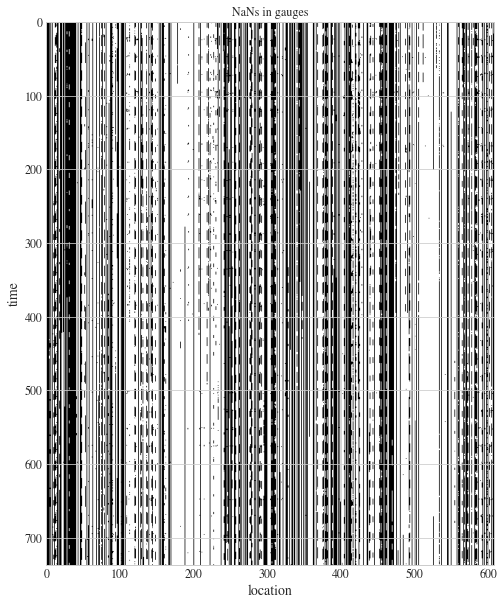

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined_all.gauge_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax.imshow(m, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in gauges')
plt.show()

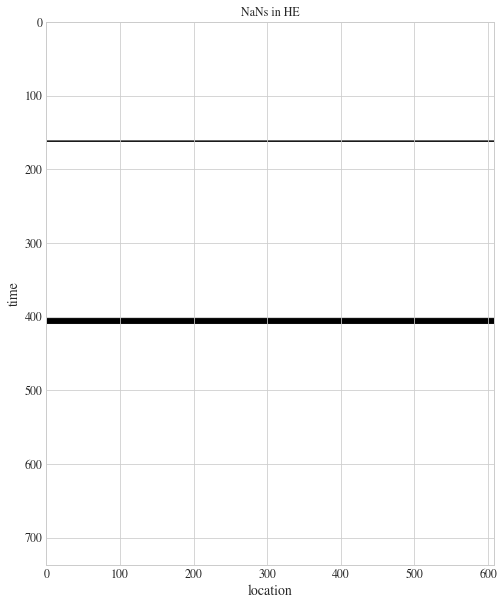

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined_all.HE_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax.imshow(m, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in HE')
plt.show()

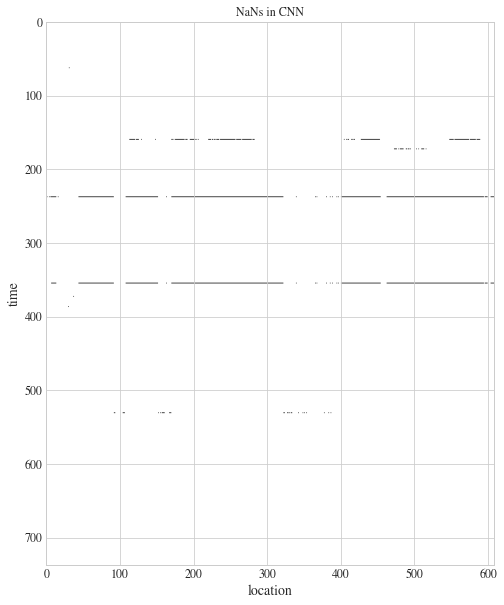

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
data = combined_all.xception_posterior_mean.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax.imshow(m, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('NaNs in CNN')
plt.show()

In [13]:
mask = np.zeros((combined_all.gauge_precip.values.shape[0], combined_all.gauge_precip.values.shape[1]))
mask[np.isnan(combined_all.gauge_precip.values)] = 1
mask[np.isnan(combined_all.HE_precip.values)] = 1
mask[np.isnan(combined_all.xception_posterior_mean.values)] = 1
print(mask)
print('missing values fraction:', mask.sum()/len(mask.flatten()))

[[0. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 0. 0.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]]
missing values fraction: 0.3793793192447524


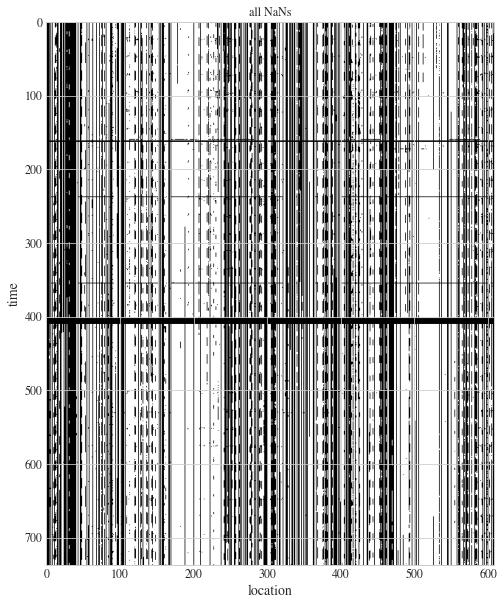

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(mask, cmap='binary')
ax.set_xlabel('location')
ax.set_ylabel('time')
ax.set_title('all NaNs')
plt.show()

In [15]:
# Make sure that comparison is done only where values are present in all datasets.
combined = combined_all.copy()
combined = combined.where(mask==0)

### Single rain gauge over time

In [16]:

def plotGaugeTimeseries(ind,start=0,end=-1):
    fig, ax = plt.subplots(figsize=(16,8))
    #plt.plot(combined.time, combined.mlp_posterior_mean[:, ind], label='mlp')
    plt.plot(combined.time[start:end], combined.xception_posterior_mean[start:end, ind], color='blue', label='CNN')
    plt.fill_between(combined.time[start:end], combined['xception_Q0.95'][start:end, ind],alpha=0.2, color='blue')
    plt.fill_between(combined.time[start:end], combined['xception_Q0.99'][start:end, ind],alpha=0.1, color='blue')
    #plt.plot(combined.time, combined.HE_precip[:, ind], label='HE')
    plt.plot(combined.time[start:end], combined.HE_precip_corr[start:end, ind], label='corrected HE')
    plt.plot(combined.time[start:end], combined.gauge_precip[start:end, ind], label='gauge')

    ax.set_ylabel('rain (mm)')
    ax.set_xlabel('datetime (hour)')
    ax.legend()

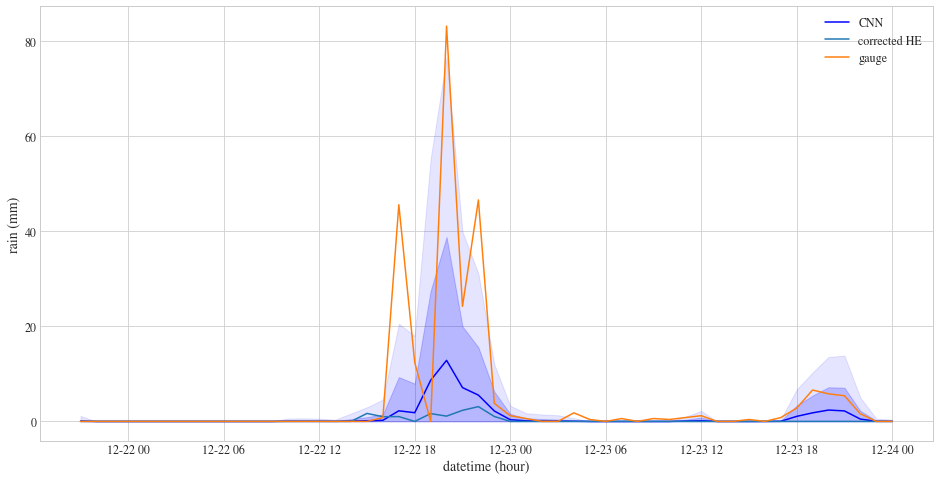

In [17]:
plotGaugeTimeseries(429,500,552) # Xerém

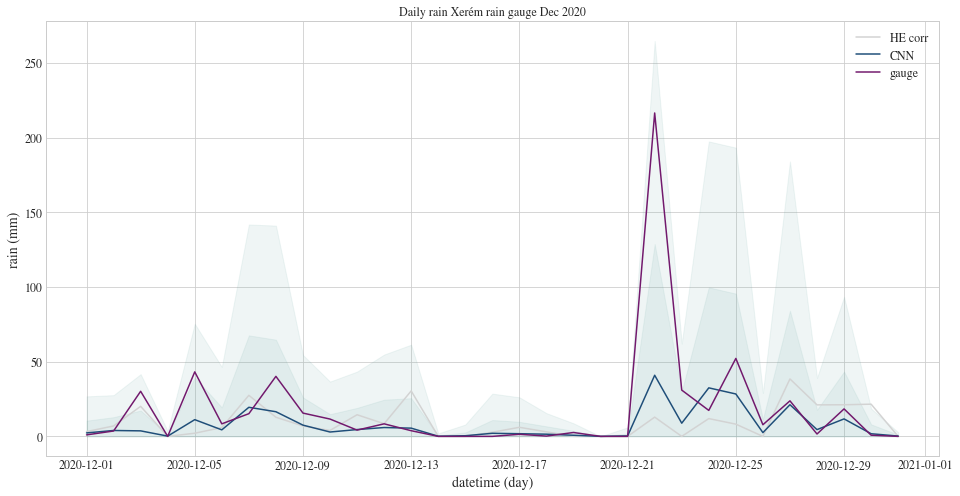

In [18]:

ind = 429
daym = combined.copy()
daym = daym.resample(time='D').sum()
fig, ax = plt.subplots(figsize=(16,8))
#plt.plot(daym.time, daym.mlp_posterior_mean[:, ind], label='mlp')
#ax.plot(daym.time, daym.HE_precip[:, ind], label='HE', color='#e6e6e6')
ax.fill_between(daym.time, daym['xception_Q0.99'][:, ind], alpha=0.1, color='#64a6a1')
ax.fill_between(daym.time, daym['xception_Q0.95'][:, ind], alpha=0.1, color='#64a6a1')

ax.plot(daym.time, daym.HE_precip_corr[:, ind], label='HE corr', color='lightgrey')
ax.plot(daym.time, daym.xception_posterior_mean[:, ind], label='CNN', color='#1f4e79')
ax.plot(daym.time, daym.gauge_precip[:, ind], label='gauge', color='#72196d')

ax.set_ylabel('rain (mm)')
ax.set_xlabel('datetime (day)')
ax.set_title('Daily rain Xerém rain gauge Dec 2020')
ax.legend()

### Scalar metrics

In [19]:
def Bias(a,b,dataset,mask):
    bias = np.mean(np.subtract(dataset[a].values,dataset[b].values)[mask==0])
    return(bias)

def MAE(a,b,dataset,mask):
    mae = np.mean(np.abs(np.subtract(dataset[a].values,dataset[b].values)[mask==0]))
    return(mae)

def MSE(a,b,dataset,mask):
    mse = np.mean(np.square(np.subtract(dataset[a].values,dataset[b].values)[mask==0]))
    return(mse)

#### Bias

In [20]:
print('HE:',Bias('gauge_precip','HE_precip',combined,mask))
print('HE corr:',Bias('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',Bias('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',Bias('gauge_precip','xception_posterior_mean',combined,mask))

HE: -0.1041845413295188
HE corr: 0.006546504557844834
MLP: 0.02128214204459453
CNN: -0.004233128358052377


#### MAE

In [21]:
print('HE:',MAE('gauge_precip','HE_precip',combined,mask))
print('HE corr:',MAE('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',MAE('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',MAE('gauge_precip','xception_posterior_mean',combined,mask))

HE: 0.39354618014600884
HE corr: 0.3000981773968421
MLP: 0.26460390683247
CNN: 0.23152983903431412


#### MSE

In [22]:
print('HE:',MSE('gauge_precip','HE_precip',combined,mask))
print('HE corr:',MSE('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',MSE('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',MSE('gauge_precip','xception_posterior_mean',combined,mask))

HE: 3.9399494848424386
HE corr: 2.4381287135261074
MLP: 2.03985636993056
CNN: 1.698436812975142


### Histograms 

In [433]:
'''
bins = np.linspace(0,80,50)
print(bins)

fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(16,8))

ax[0,0].hist(combined.gauge_precip.values[mask==0].flatten(), bins=bins)
ax[0,0].set_title('gauges')
#ax[0,0].set_yscale("log")

ax[0,1].hist(combined.HE_precip.values[mask==0].flatten(), bins=bins)
ax[0,1].set_title('HE')
#ax[0,1].set_yscale("log")

ax[0,2].hist(combined.HE_precip_corr.values[mask==0].flatten(), bins=bins)
ax[0,2].set_title('He corr')
#ax[0,2].set_yscale("log")

ax[1,0].hist(combined.mlp_posterior_mean.values[mask==0].flatten(), bins=bins)
ax[1,0].set_title('MLP')
#ax[1,0].set_yscale("log")

ax[1,1].hist(combined.xception_posterior_mean.values[mask==0].flatten(), bins=bins)
ax[1,1].set_title('CNN')
#ax[1,1].set_yscale("log")

plt.show()
'''

'\nbins = np.linspace(0,80,50)\nprint(bins)\n\nfig, ax = plt.subplots(nrows=2,ncols=3, figsize=(16,8))\n\nax[0,0].hist(combined.gauge_precip.values[mask==0].flatten(), bins=bins)\nax[0,0].set_title(\'gauges\')\n#ax[0,0].set_yscale("log")\n\nax[0,1].hist(combined.HE_precip.values[mask==0].flatten(), bins=bins)\nax[0,1].set_title(\'HE\')\n#ax[0,1].set_yscale("log")\n\nax[0,2].hist(combined.HE_precip_corr.values[mask==0].flatten(), bins=bins)\nax[0,2].set_title(\'He corr\')\n#ax[0,2].set_yscale("log")\n\nax[1,0].hist(combined.mlp_posterior_mean.values[mask==0].flatten(), bins=bins)\nax[1,0].set_title(\'MLP\')\n#ax[1,0].set_yscale("log")\n\nax[1,1].hist(combined.xception_posterior_mean.values[mask==0].flatten(), bins=bins)\nax[1,1].set_title(\'CNN\')\n#ax[1,1].set_yscale("log")\n\nplt.show()\n'

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80.]


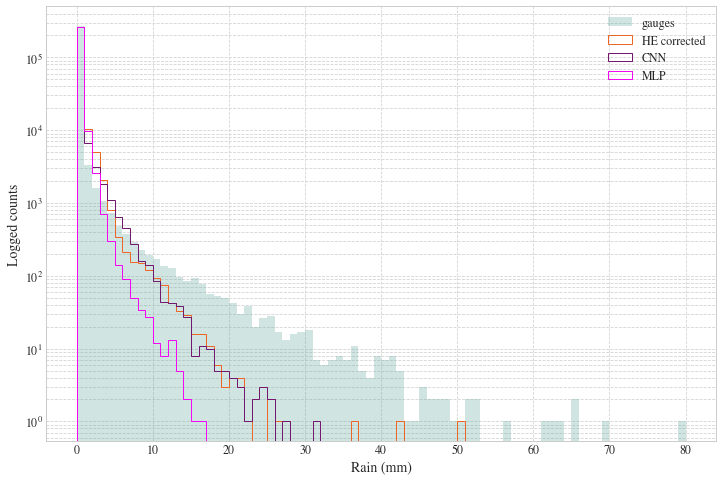

In [563]:
bins = np.linspace(0,80,81)
print(bins)

alpha=1
histtype='step'
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(combined.gauge_precip.values[mask==0].flatten(), histtype='bar', bins=bins,alpha=0.3, label='gauges', color='#64a6a1')
#ax.hist(combined.HE_precip.values[mask==0].flatten(), histtype=histtype, bins=bins, alpha=alpha, label='HE')
ax.hist(combined.HE_precip_corr.values[mask==0].flatten(), histtype=histtype, bins=bins, alpha=alpha, label='HE corrected', color='#ec6726')
ax.hist(combined.xception_posterior_mean.values[mask==0].flatten(), histtype=histtype, bins=bins, alpha=alpha, label='CNN', color='#72196d')
#ax.hist(combined.mlp_posterior_mean.values[mask==0].flatten(), histtype=histtype, bins=bins, alpha=alpha, label='MLP', color='#f308f3')
ax.set_yscale("log")
ax.grid(True,which="both",ls="--",c='lightgray')
ax.set_xlabel('Rain (mm)')
ax.set_ylabel('Logged counts')
ax.legend()
plt.show()


[ 0.1         0.10691309  0.1143041   0.12220605  0.13065427  0.13968652
  0.14934318  0.15966742  0.17070538  0.1825064   0.19512324  0.20861229
  0.22303386  0.2384524   0.25493684  0.27256086  0.29140325  0.31154824
  0.33308586  0.3561124   0.38073079  0.40705107  0.43519089  0.46527605
  0.49744102  0.53182959  0.56859547  0.60790301  0.64992792  0.69485805
  0.74289425  0.79425123  0.84915857  0.9078617   0.97062304  1.03772313
  1.10946191  1.18616006  1.26816042  1.35582955  1.44955933  1.54976873
  1.65690571  1.77144917  1.89391112  2.02483899  2.16481802  2.31447393
  2.4744757   2.64553855  2.82842712  3.02395896  3.2330081   3.45650901
  3.69546074  3.95093143  4.22406306  4.51607653  4.82827716  5.16206052
  5.51891865  5.90044671  6.30835016  6.74445237  7.21070273  7.70918542
  8.24212869  8.81191484  9.42109084 10.07237975 10.76869287 11.51314278
 12.30905722 13.15999398 14.06975679 15.04241237 16.08230855 17.19409373
 18.38273768 19.6535537  21.01222244 22.46481722 24

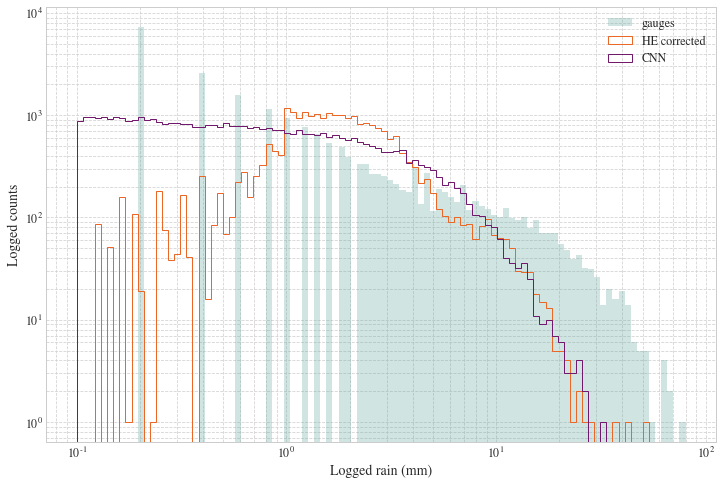

In [559]:
logbins = np.logspace(np.log10(0.1),np.log10(80),101)
print(logbins)

alpha=1
histtype='step'
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(combined.gauge_precip.values[mask==0].flatten(), histtype='bar', bins=logbins,alpha=0.3, label='gauges', color='#64a6a1')
#ax.hist(combined.HE_precip.values[mask==0].flatten(), histtype=histtype, bins=logbins, alpha=alpha, label='HE')
ax.hist(combined.HE_precip_corr.values[mask==0].flatten(), histtype=histtype, bins=logbins, alpha=alpha, label='HE corrected', color='#ec6726')
ax.hist(combined.xception_posterior_mean.values[mask==0].flatten(), histtype=histtype, bins=logbins, alpha=alpha, label='CNN', color='#72196d')
#ax.hist(combined.mlp_posterior_mean.values[mask==0].flatten(), histtype=histtype, bins=logbins, alpha=alpha, label='MLP')
ax.set_yscale("log")
ax.set_xscale('log')
ax.set_xlabel('Logged rain (mm)')
ax.set_ylabel('Logged counts')
ax.grid(True,which="both",ls="--",c='lightgray')
ax.legend()
plt.show()


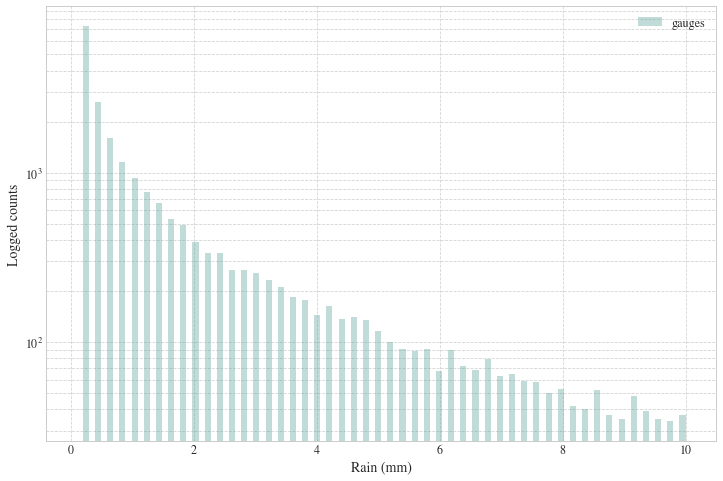

In [437]:
bins = np.linspace(0.1,10,101)
#print(bins)
#bins=100
alpha=0.4
histtype='bar'
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(combined.gauge_precip.values[mask==0].flatten(), histtype=histtype, bins=bins,alpha=alpha, label='gauges',  color='#64a6a1')
#ax.hist(combined.HE_precip.values[mask==0].flatten(), histtype=histtype, bins=bins, alpha=alpha, label='HE')
#ax.hist(combined.HE_precip_corr.values[mask==0].flatten(), histtype=histtype, bins=bins, alpha=alpha, label='HE corrected', color='#ec6726')
#ax.hist(combined.xception_posterior_mean.values[mask==0].flatten(), histtype=histtype, bins=bins, alpha=alpha, label='CNN', color='#72196d')
#ax.hist(combined.mlp_posterior_mean.values[mask==0].flatten(), histtype=histtype, bins=bins, alpha=alpha, label='MLP')
ax.set_yscale("log")
ax.set_xlabel('Rain (mm)')
ax.set_ylabel('Logged counts')
ax.grid(True,which="both",ls="--",c='lightgray')
ax.legend()
plt.show()


### By region

In [27]:
reg = ['N', 'SE', 'CW', 'S', 'NE'] #np.unique(metadata.region)
print(reg)
mse_by_region = np.zeros((len(reg),4))

['N', 'SE', 'CW', 'S', 'NE']


In [28]:
for i in range(len(reg)):
    locs = list(metadata.index[metadata.region == reg[i]])
    print(len(locs))
    selection = combined.copy().isel(location=locs)
    mse_by_region[i,0] = MSE('gauge_precip', 'HE_precip', selection, mask[:,locs])
    mse_by_region[i,1] = MSE('gauge_precip', 'HE_precip_corr', selection, mask[:,locs])
    mse_by_region[i,2] = MSE('gauge_precip', 'mlp_posterior_mean', selection, mask[:,locs])
    mse_by_region[i,3] = MSE('gauge_precip', 'xception_posterior_mean', selection, mask[:,locs])

100
149
115
95
150


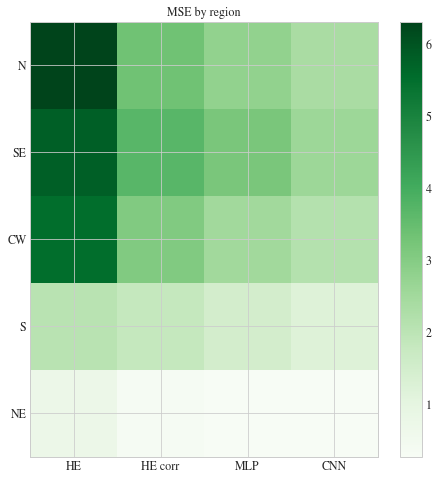

In [29]:

fig, ax = plt.subplots(figsize=(8,8))
m = ax.imshow(mse_by_region, cmap='Greens')
ax.set_yticks(list(range(len(reg))))
ax.set_yticklabels(reg)
mods = ['HE', 'HE corr', 'MLP', 'CNN']
ax.set_xticks(list(range(len(mods))))
ax.set_xticklabels(mods)
ax.set_title('MSE by region')
fig.colorbar(m)
plt.show()

### Diurnal cycle

In [30]:
import datetime
import timezonefinder, pytz

tf = timezonefinder.TimezoneFinder()

def getTimeZone(lat, lon):
    timezone_str = tf.certain_timezone_at(lat=lat, lng=lon)

    if timezone_str is None:
        print( "Could not determine the time zone")
        return(None)
    else:
        # Assuming same utc offset at given location throughout whole timeperiod Dec 2020
        timezone = pytz.timezone(timezone_str)
        dt = datetime.datetime(2020,12,1)
    return(timezone.utcoffset(dt).total_seconds()/3600.0)

In [31]:
def UTCtoLocal(dataset,mdat):
    shift = []
    for i in mdat.index:
        shift.append(getTimeZone(mdat.lat[i], mdat.lon[i]))
        
    ind_to_shift = []
    for s in np.unique(shift):
        ind_to_shift.append(list(np.where(shift==s)))
        
    di = dataset.copy()
    dj = dataset.copy()
    
    abs_diff = int(np.max(np.abs(np.unique(shift))))
    to_add = dj.time.min()+np.timedelta64(abs_diff,'h')
    
    dj = dj.where(dj.time<to_add, drop=True)
    dj = dj.where(dj.time<di.time.min())
    
    dj = dj.assign_coords(time=di.time[:abs_diff]-np.timedelta64(abs_diff,'h'))
    
    dext = xr.concat([dj, di], "time")
    
    datasets = []
    for i in range(len(np.unique(shift))):
        print(int(np.unique(shift)[i]))
        #print(ind_to_shift[i][0])
        selection = dext.copy().isel(location=ind_to_shift[i][0])
        selection = selection.shift(time=int(np.unique(shift)[i]))
        datasets.append(selection)    
        
    dshifted = xr.concat(datasets, "location")
    dshifted = dshifted.sortby("location")
    
    return(dshifted)

In [32]:
combined_local_time = UTCtoLocal(combined, metadata)

-5
-4
-3
-2


In [440]:
def diurnal_cycle(dataset):
    di = dataset.copy()
    di = di.mean(dim='location')
    di = di.groupby('time.hour')
    st = di.std()
    me = di.mean()

    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(me.hour, me.gauge_precip, label='gauges', color='#64a6a1')
    ax.plot(me.hour, me.HE_precip_corr, label='HE corrected', linestyle='dashdot', color='#ec6726')
    ax.plot(me.hour, me.xception_posterior_mean, label='CNN', linestyle='dashed', color='#72196d')
    ax.fill_between(me.hour, me.gauge_precip+st.gauge_precip,
                    me.gauge_precip-st.gauge_precip, linestyle='--', alpha=0.1, color='#64a6a1')
    ax.fill_between(me.hour, me.HE_precip_corr+st.HE_precip_corr, 
                    me.HE_precip_corr-st.HE_precip_corr, alpha=0.1, color='#ec6726')
    ax.fill_between(me.hour, me.xception_posterior_mean+st.xception_posterior_mean,
                       me.xception_posterior_mean-st.xception_posterior_mean, alpha=0.1, color='#72196d')

    ax.set_ylabel('Rain (mm)')
    ax.set_xlabel('Time (hour)')
    ax.legend(loc='upper left')

In [441]:
#diurnal_cycle(combined)

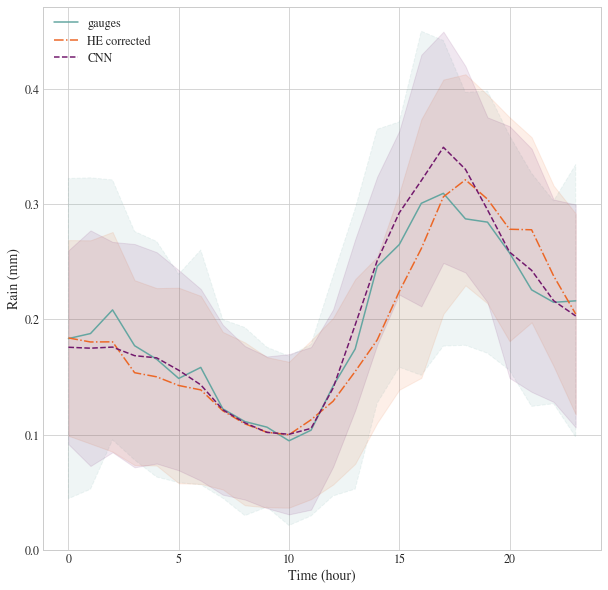

In [442]:
diurnal_cycle(combined_local_time) #time with local utc offset

### 2D histograms

In [36]:
#plt.scatter(combined.gauge_precip.values[mask==0].flatten(), combined.HE_precip_corr.values[mask==0].flatten())

In [37]:
#plt.scatter(combined.gauge_precip.values[mask==0].flatten(), combined.xception_posterior_mean.values[mask==0].flatten())

In [38]:
'''

from matplotlib.colors import Normalize
norm = Normalize(0, 200)

#bins = np.logspace(-2, 2, 101)
y = #combined.xception_posterior_mean.values[mask==0].flatten()#combined.HE_precip_corr.values[mask==0].flatten()
x = combined.gauge_precip.values[mask==0].flatten()
bins_x = np.linspace(0,np.max(x),101)
bins_y = np.linspace(0,np.max(y),101)


freqs, _, _ = np.histogram2d(x, y, bins=[bins_x,bins_y])

print(freqs)

fig, ax = plt.subplots(figsize=(12,10))
im = ax.pcolormesh(bins_x, bins_y, freqs.T, cmap='viridis',norm=norm)
#ax.set_xlim([1e-2, 1e2])
#ax.set_ylim([1e-2, 1e2])
#ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_xlabel("Reference rain rate [mm / h]")
#ax.set_ylabel("Predicted rain rate [mm / h]")
ax.plot(bins_x, bins_y, c="grey", ls="--")
ax.set_aspect(1.0)
fig.colorbar(im,aspect=2)
plt.tight_layout()
plt.show()


'''

'\n\nfrom matplotlib.colors import Normalize\nnorm = Normalize(0, 200)\n\n#bins = np.logspace(-2, 2, 101)\ny = #combined.xception_posterior_mean.values[mask==0].flatten()#combined.HE_precip_corr.values[mask==0].flatten()\nx = combined.gauge_precip.values[mask==0].flatten()\nbins_x = np.linspace(0,np.max(x),101)\nbins_y = np.linspace(0,np.max(y),101)\n\n\nfreqs, _, _ = np.histogram2d(x, y, bins=[bins_x,bins_y])\n\nprint(freqs)\n\nfig, ax = plt.subplots(figsize=(12,10))\nim = ax.pcolormesh(bins_x, bins_y, freqs.T, cmap=\'viridis\',norm=norm)\n#ax.set_xlim([1e-2, 1e2])\n#ax.set_ylim([1e-2, 1e2])\n#ax.set_xscale("log")\n#ax.set_yscale("log")\n#ax.set_xlabel("Reference rain rate [mm / h]")\n#ax.set_ylabel("Predicted rain rate [mm / h]")\nax.plot(bins_x, bins_y, c="grey", ls="--")\nax.set_aspect(1.0)\nfig.colorbar(im,aspect=2)\nplt.tight_layout()\nplt.show()\n\n\n'

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.colors import LogNorm
#viridis = cm.get_cmap('viridis', 256)
#newcolors = viridis(np.linspace(0, 1, 256))
#pink = np.array([248/256, 24/256, 148/256, 1])
#newcolors[:25, :] = pink
#newcmp = ListedColormap(newcolors)

#big = cm.get_cmap('autumn_r', 512)
big = cm.get_cmap('magma', 512)
newcmp = ListedColormap(big(np.linspace(0.05, 0.95, 256)))

In [305]:
'''
bins = np.linspace(-40,60,80)
f, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].set_yscale("log")
ax[0].hist(np.subtract(combined['gauge_precip'].values,
                    combined['xception_posterior_mean'].values)[mask==0].flatten(), 
           alpha=0.7, bins=bins, color='#72196d', label='CNN')
ax[0].hist(np.subtract(combined['gauge_precip'].values,
                    combined['HE_precip_corr'].values)[mask==0].flatten(), 
           alpha=0.9, bins=bins, color='#ec6726', label='HE corrected', histtype='step')
ax[0].set_ylabel('Logged counts')
ax[0].set_xlabel('Rain rate difference (mm)')
ax[0].axvline(x=0.0, color='grey', alpha=0.5, linestyle='dashed')
ax[0].legend()
ax[1].set_yscale("log")
ax[1].hist(np.subtract(combined['gauge_precip'].values,
                    combined['HE_precip_corr'].values)[mask==0].flatten(), 
           alpha=0.7, bins=bins, color='#ec6726', label='HE corrected')
ax[1].hist(np.subtract(combined['gauge_precip'].values,
                    combined['xception_posterior_mean'].values)[mask==0].flatten(), 
           alpha=0.9, bins=bins, color='#72196d', label='CNN', histtype='step')
ax[1].set_ylabel('Logged counts')
ax[1].set_xlabel('Rain rate difference (mm)')
ax[1].axvline(x=0.0, color='grey', alpha=0.5, linestyle='dashed')
ax[1].legend()
plt.tight_layout()
'''

'\nbins = np.linspace(-40,60,80)\nf, ax = plt.subplots(ncols=2, figsize=(10,5))\nax[0].set_yscale("log")\nax[0].hist(np.subtract(combined[\'gauge_precip\'].values,\n                    combined[\'xception_posterior_mean\'].values)[mask==0].flatten(), \n           alpha=0.7, bins=bins, color=\'#72196d\', label=\'CNN\')\nax[0].hist(np.subtract(combined[\'gauge_precip\'].values,\n                    combined[\'HE_precip_corr\'].values)[mask==0].flatten(), \n           alpha=0.9, bins=bins, color=\'#ec6726\', label=\'HE corrected\', histtype=\'step\')\nax[0].set_ylabel(\'Logged counts\')\nax[0].set_xlabel(\'Rain rate difference (mm)\')\nax[0].axvline(x=0.0, color=\'grey\', alpha=0.5, linestyle=\'dashed\')\nax[0].legend()\nax[1].set_yscale("log")\nax[1].hist(np.subtract(combined[\'gauge_precip\'].values,\n                    combined[\'HE_precip_corr\'].values)[mask==0].flatten(), \n           alpha=0.7, bins=bins, color=\'#ec6726\', label=\'HE corrected\')\nax[1].hist(np.subtract(combined[

[-40. -39. -38. -37. -36. -35. -34. -33. -32. -31. -30. -29. -28. -27.
 -26. -25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13.
 -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.]


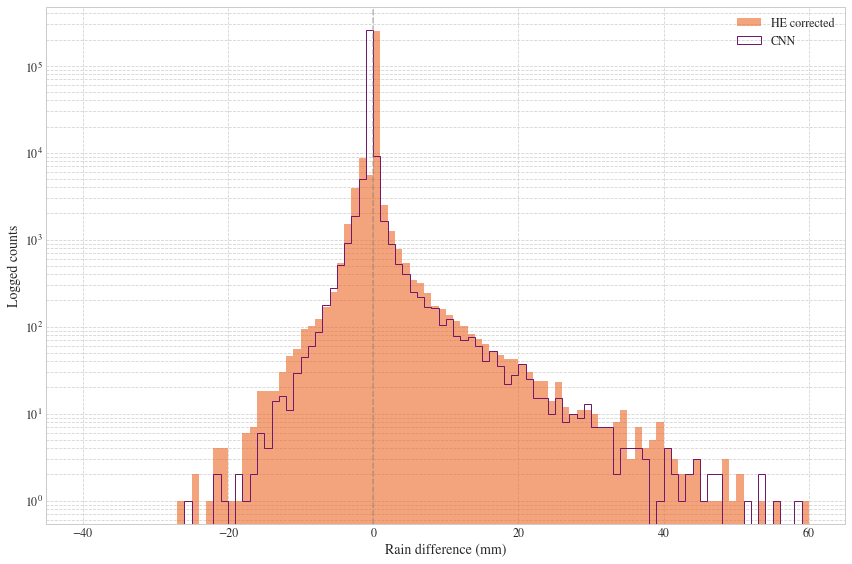

In [443]:

bins = np.linspace(-40,60,101)
print(bins)
f, ax = plt.subplots(figsize=(12,8))
ax.set_yscale("log")
ax.hist(np.subtract(combined['gauge_precip'].values,
                    combined['HE_precip_corr'].values)[mask==0].flatten(), 
           alpha=0.6, bins=bins, color='#ec6726', label='HE corrected')
ax.hist(np.subtract(combined['gauge_precip'].values,
                    combined['xception_posterior_mean'].values)[mask==0].flatten(), 
           alpha=1, bins=bins, color='#72196d', label='CNN', histtype='step')
ax.set_ylabel('Logged counts')
ax.set_xlabel('Rain difference (mm)')
ax.axvline(x=0.0, color='grey', alpha=0.5, linestyle='dashed')
ax.grid(True,which="both",ls="--",c='lightgray')  
ax.legend()
plt.tight_layout()

In [445]:
'''
bias_list = []
mae_list = []
ils = [0, 1e0, 1e1, 5e1, 1e2] #list(range(0,80,10))#
y = combined['gauge_precip'].values
p = combined['xception_posterior_mean'].values
for i in range(len(ils)-1):
    inds_in_ils = (y>=ils[i]) & (y<ils[i+1])
    #print(y[inds_in_ils])
    #print(p[inds_in_ils])
    bias_list.append(np.mean(np.subtract(y[inds_in_ils], p[inds_in_ils])))
    mae_list.append(np.mean(np.abs(np.subtract(y[inds_in_ils], p[inds_in_ils]))))
    
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ils[:-1], bias_list)
ax.plot(ils[:-1], mae_list)
'''

"\nbias_list = []\nmae_list = []\nils = [0, 1e0, 1e1, 5e1, 1e2] #list(range(0,80,10))#\ny = combined['gauge_precip'].values\np = combined['xception_posterior_mean'].values\nfor i in range(len(ils)-1):\n    inds_in_ils = (y>=ils[i]) & (y<ils[i+1])\n    #print(y[inds_in_ils])\n    #print(p[inds_in_ils])\n    bias_list.append(np.mean(np.subtract(y[inds_in_ils], p[inds_in_ils])))\n    mae_list.append(np.mean(np.abs(np.subtract(y[inds_in_ils], p[inds_in_ils]))))\n    \nfig, ax = plt.subplots(figsize=(8,8))\nax.plot(ils[:-1], bias_list)\nax.plot(ils[:-1], mae_list)\n"

Text(0, 0.5, 'Predicted rain rate (mm)')

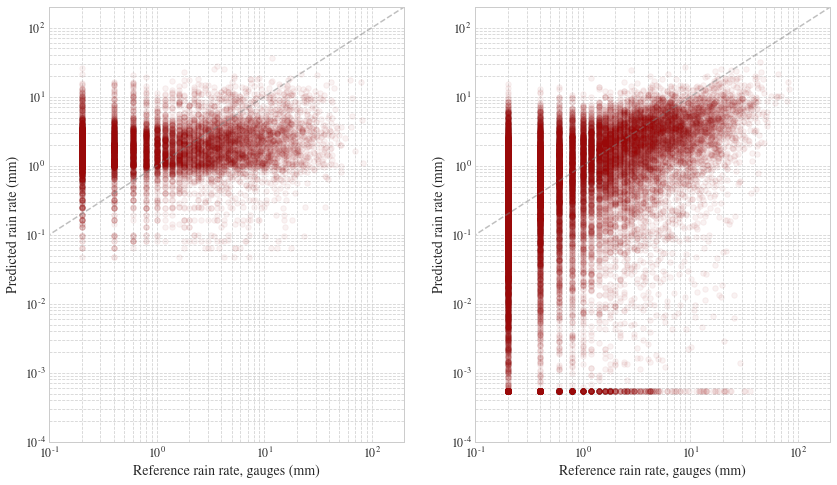

In [548]:
fig, ax = plt.subplots(ncols=2, figsize=(14,8))
vals = np.array(list(range(0,1000)))
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].plot(vals, vals, c='gray', ls="--", alpha=0.5)

ax[0].grid(True,which="both",ls="--",c='lightgray') 
ax[0].scatter(combined.gauge_precip.values[mask==0].flatten(), 
           combined.HE_precip_corr.values[mask==0].flatten(), alpha=0.05, color='#990909', s=30)
ax[0].set_ylim([1e-4, 2e2])
ax[0].set_xlim([1e-1, 2e2])
ax[0].set_xlabel("Reference rain rate, gauges (mm)")
ax[0].set_ylabel("Predicted rain rate (mm)")

ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].plot(vals, vals, c='gray', ls="--", alpha=0.5)

ax[1].grid(True,which="both",ls="--",c='lightgray') 
ax[1].scatter(combined.gauge_precip.values[mask==0].flatten(), 
           combined.xception_posterior_mean.values[mask==0].flatten(), alpha=0.05, color='#990909', s=30)
ax[1].set_ylim([1e-4, 2e2])
ax[1].set_xlim([1e-1, 2e2])
ax[1].set_xlabel("Reference rain rate, gauges (mm)")
ax[1].set_ylabel("Predicted rain rate (mm)")
#ax.set_aspect(1.0)

In [501]:
def hist2D(y_true, y_pred):
    bins = np.logspace(-4, 3, 100)# 81)
    
    
    freqs_fc, _, _ = np.histogram2d(y_true, y_pred, bins=bins)
    #print(freqs_fc)

    freqs_fc[freqs_fc==0.0] = np.nan
    
    print(np.nanmax(freqs_fc))
    #norm = Normalize(0, 100)
    norm = LogNorm(vmin=np.nanmin(freqs_fc), vmax=3000)#np.nanmax(freqs_fc))
    
    f, ax = plt.subplots(figsize=(8,8))
    m = ax.pcolormesh(bins, bins, freqs_fc.T, 
                      norm=norm, 
                      cmap=newcmp) #viridis_r, YlOrRd, magma
    ax.set_xlim([1e-2, 1e3])
    ax.set_ylim([1e-4, 1e3])

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Reference rain rate, gauges (mm)")
    ax.set_ylabel("Predicted rain rate (mm)")
    ax.plot(bins, bins, c="grey", ls="--")
    ax.grid(True,which="both",ls="--",c='lightgray')  
    #ax.set_aspect(1.0)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    plt.colorbar(m, cax=cax)
    
    plt.tight_layout()

2191.0


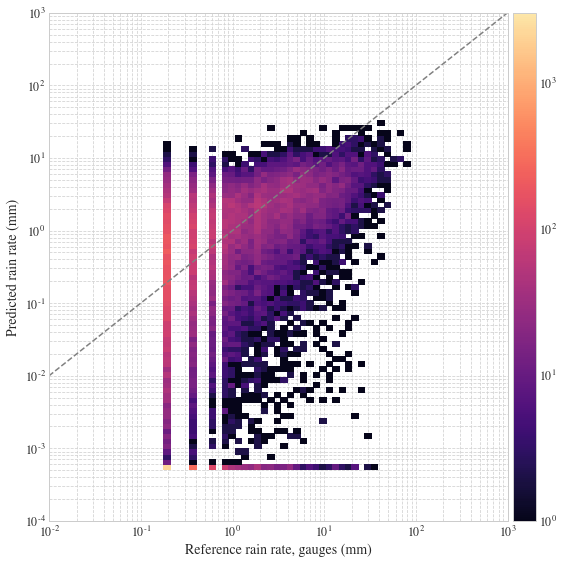

In [502]:
hist2D(combined.gauge_precip.values[mask==0].flatten(), 
      combined.xception_posterior_mean.values[mask==0].flatten())

177.0


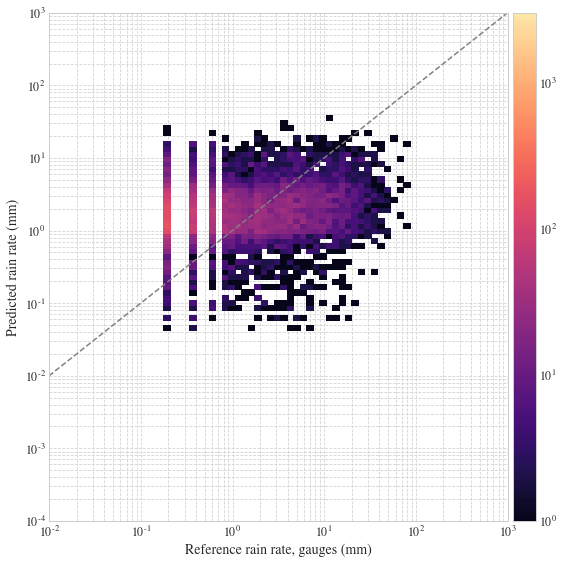

In [503]:
hist2D(combined.gauge_precip.values[mask==0].flatten(), 
      combined.HE_precip_corr.values[mask==0].flatten())

107.0


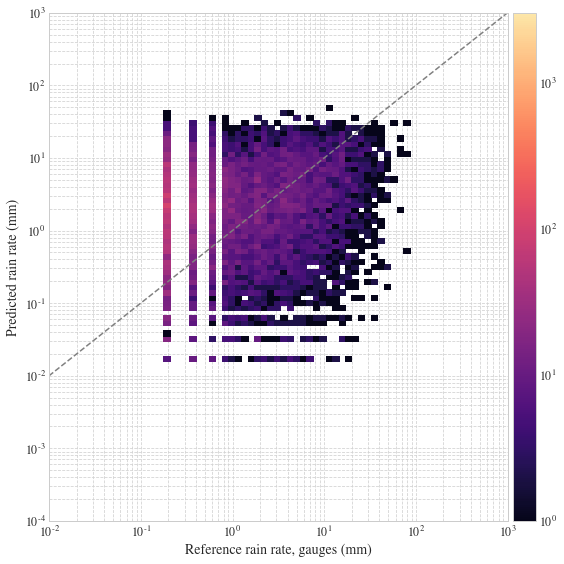

In [504]:
hist2D(combined.gauge_precip.values[mask==0].flatten(), 
      combined.HE_precip.values[mask==0].flatten())

1123.0


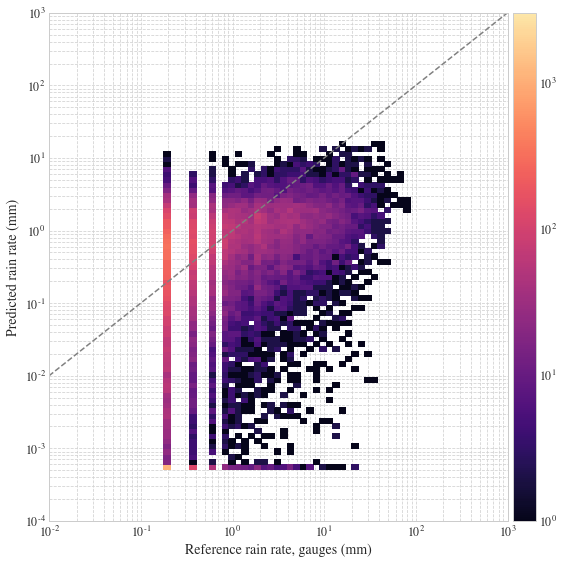

In [505]:
hist2D(combined.gauge_precip.values[mask==0].flatten(), 
      combined.mlp_posterior_mean.values[mask==0].flatten())

In [239]:
def diff2(b,dataset,mask):

    
    y_true = dataset['gauge_precip'].values[mask==0].flatten()
    diff = (dataset['gauge_precip'].values - dataset[b].values)[mask==0].flatten()#np.subtract(dataset[a].values, dataset[b].values)[mask==0].flatten()
    
    print('y true max', np.max(y_true))
    print('diff max', np.max(diff))
    
    print('y true min', np.min(y_true))
    print('diff min', np.min(diff))

    bins_y = np.linspace(-30,90,100)
    bins_x = bins_y
    
    freqs_fc, _, _ = np.histogram2d(y_true, diff, bins=(bins_x,bins_y))
    freqs_fc[freqs_fc==0.0] = np.nan

    norm = LogNorm(vmin=np.nanmin(freqs_fc), vmax=1e6)#np.nanmax(freqs_fc), clip=1e6)
        
    f, ax = plt.subplots(figsize=(8, 8))

    ax.axhline(0, bins_x[0], bins_x[-1], zorder=0, c="grey", ls="--", alpha=0.5)
    ax.plot(bins_x, bins_y,  zorder=0, c='lightgray', ls="--", alpha=0.5)
    m = ax.pcolormesh(bins_x, bins_y, freqs_fc.T, cmap=newcmp, norm=norm)
    ax.grid(True,which="both",ls="--",c='lightgray')  
    ax.set_aspect(1.0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    plt.colorbar(m, cax=cax)
    
    ax.set_xlabel("Reference rain rate, gauges (mm)")
    ax.set_ylabel("Reference minus predicted rain rate (mm)")
    plt.tight_layout()

y true max 83.2
diff max 70.39267272949219
y true min 0.0
diff min -25.899417877197266


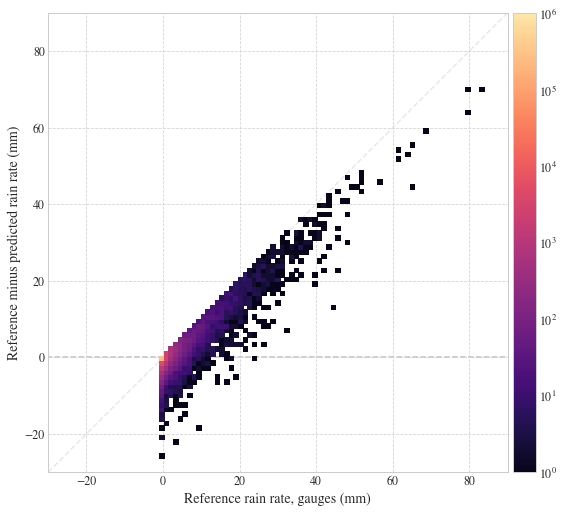

In [240]:
diff2('xception_posterior_mean',combined,mask)

In [393]:
'''
import seaborn as sns
heatmap_df = pd.DataFrame()
heatmap_df['y_true'] = combined.gauge_precip.values[mask==0].flatten()
heatmap_df['y_pred'] = combined.xception_posterior_mean.values[mask==0].flatten()
heatmap_mask = (heatmap_df < 1e-2)
sns.displot(heatmap_df[~heatmap_mask], x="y_true", y="y_pred",
            kind="kde",
            fill=True,
            levels=[.05, .1, .5, .8, 1.], 
            color='grey',
            alpha=0.6,
            log_scale=(True, True))
'''

'\nimport seaborn as sns\nheatmap_df = pd.DataFrame()\nheatmap_df[\'y_true\'] = combined.gauge_precip.values[mask==0].flatten()\nheatmap_df[\'y_pred\'] = combined.xception_posterior_mean.values[mask==0].flatten()\nheatmap_mask = (heatmap_df < 1e-2)\nsns.displot(heatmap_df[~heatmap_mask], x="y_true", y="y_pred",\n            kind="kde",\n            fill=True,\n            levels=[.05, .1, .5, .8, 1.], \n            color=\'grey\',\n            alpha=0.6,\n            log_scale=(True, True))\n'

In [127]:
dat = combined.gauge_precip.values[mask==0].flatten()
print(np.unique(dat))

[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.
 11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8
 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4
 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6 21.8 22.  22.2
 22.4 22.6 22.8 23.  23.2 23.4 23.6 23.8 24.  24.2 24.4 24.6 24.8 25.
 25.2 25.4 25.6 25.8 26.  26.2 26.4 26.6 26.8 27.  27.2 27.4 27.6 27.8
 28.  28.2 28.4 28.6 28.8 29.  29.2 29.4 29.6 29.8 30.  30.2 30.4 30.6
 30.8 31.  31.4 31.6 32.  32.2 32.4 32.6 33.2 33.6 33.8 34.  34.4 34.6
 34.8 35.  35.2 35.4 35.6 35.8 36.  36.2 36.4 36.6 36.8 37.  37.2 37.6
 38.4 38.6 38.8 39.  39.2 39.6 39.8 40.2 40.4 40.6 40.8 41.2 41.6 41.8
 42.4 42

In [423]:
y = combined.gauge_precip.values[mask==0].flatten()
p = combined.xception_posterior_mean.values[mask==0].flatten()

p[p<=1e-3] = 0.0

TP = (p[y>0.0]>0.0).sum() #Is rain, predict rain
TN = (p[y==0.0]==0.0).sum() #Is no rain, predict no rain
FP = (p[y==0.0]>0.0).sum() #Is no rain, predict rain
FN = (p[y>0.0]==0.0).sum() #Is rain, predict no rain

print('TP, Is rain, predict rain:', TP)
print('TN, Is no rain, predict no rain:', TN)
print('FP, Is no rain, predict rain:', FP)
print('FN, Is rain, predict no rain:', FN)

TPR = (TP/(TP+FN)) #Sensitivity or Recall (POD=hits/(hits+misses))
print('TPR', "{:.2f}".format(TPR))
TNR = (TN/(TN+FP)) #Specificity
#print('TPR', "{:.2f}".format(TNR))
PPV = (TP/(TP+FP)) #Precision
#print('PPV', "{:.2f}".format(PPV))
PNV = (TN/(TN+FN))
#print('PNV', "{:.2f}".format(PNV))

FAR = (FP/(FP+FN)) #false alarms/(false alarms+hits)
print('FAR', "{:.2f}".format(FAR)) 

CSI = TP/(TP+FN+FP) #hits/(hits+misses+false alarms)
print('CSI', "{:.2f}".format(CSI))

TP, Is rain, predict rain: 19202
TN, Is no rain, predict no rain: 192127
FP, Is no rain, predict rain: 64522
FN, Is rain, predict no rain: 3082
TPR 0.86
FAR 0.95
CSI 0.22


In [128]:
'''
def hej(y_true, y_pred):
    norm = Normalize(0, 100)
    bins = np.logspace(-2, 2, 81)

    #freqs_fc, _, _ = np.histogram2d(y_true, y_pred, bins=bins)
    #print(freqs_fc)

    #freqs_fc[freqs_fc==0.0] = np.nan
    medians = []
    
    for i in range(len(bins)-1):
        tmp = y_pred[(y_pred>bins[i])&(y_pred<=bins[i+1])]
        if len(tmp)>0:
            #print(np.percentile(tmp, [25, 50, 75]))
            medians.append(np.percentile(tmp, [25, 50, 75]))

        else:
            medians.append([np.nan, np.nan, np.nan])
    medians = np.array(medians)
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(bins, bins, c="grey", ls="--")
    ax.plot(bins[:-1], medians[:,1])
    #ax.plot(bins[:-1], medians[:,0])
    #ax.plot(bins[:-1], medians[:,2])
    ax.set_xlim([1e-1, 1e2])
    ax.set_ylim([1e-1, 1e2])

    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.tight_layout()
    
    #return(medians)
'''

In [258]:
#hej(combined.gauge_precip.values[mask==0].flatten(), combined.xception_posterior_mean.values[mask==0].flatten())